In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.lines import Line2D
from pathlib import Path
import sklearn
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
import pickle
import pyensembl
from pyensembl import EnsemblRelease
import statistics
import scipy.stats as stats

##### change HERE #####
#LGG: Lower Grade Glioma, KICH: Kidney Chromophobe
disease = 'KICH'
#True: miRNA level regression, False: (miRNA, gene) level regression
regression_mirna = False 
path = Path('transcript_data')
tcga_path = Path(path/disease)
#######################

In [4]:
#define methods

#returns all bs_counts but with tarpmir information if available
def get_common_bs(bs_counts, bs_tarp):
    bs_counts['gene_id'] = bs_counts['gene_id'].str.split('.', expand=True)[0]
    bs_counts['exon_id'] = bs_counts['exon_id'].str.split('.', expand=True)[0]
    bs_counts.rename(columns = {'sample':'miRNA'}, inplace = True)
    bs = bs_counts[['miRNA','gene_id','exon_id','coefficient']].merge(bs_tarp, how='left', on=['miRNA','exon_id'],suffixes=['_counts', '_tarp'])
    bs['binding_tarpmir'] = False
    bs.loc[~bs.binding_probability.isna(),'binding_tarpmir'] = True
    bs['binding_net'] = bs['coefficient'] < 0
    bs['common'] = bs['binding_net'] & bs['binding_tarpmir']
    return bs

#split data into train and test subsets with trainsplit between 0 and 1
def split_train_test(data, train_split=0.8):
    train_split = int(train_split * len(data))
    train = data[:train_split]
    test = data[train_split:]
    return train, test

def read_in_expression(tcga_path):
    exon_counts = pd.read_pickle(tcga_path/'exon_counts.pickle')
    exon_counts.columns = [tuplee[0] for tuplee in exon_counts.columns.str.split('.',expand=True)] #here we dont use the version of a exon
    mirna_counts = pd.read_pickle(tcga_path/'miRNA_counts.pickle')
    return exon_counts,mirna_counts

def run_gene_level_elastic_net_regression(bs, mirna_counts, exon_counts):
    bs_gene_level = bs.groupby(['miRNA','gene_id']).agg({'exon_id':lambda x : list(x),'coefficient':lambda x : list(x), 'common':lambda x : list(x)})
    bs_gene_level['keep_gene'] = bs.groupby(['miRNA','gene_id']).apply(lambda x: len(x.loc[(x.coefficient == x.coefficient.min()) & (x.common == True)]) > 0)
    print(f'filter (mirna,gene)-pairs where most negative coefficient is also in TarPmiR\n  Number (mirna,gene)-pairs before: {len(bs_gene_level)}')
    bs_gene_level = bs_gene_level[bs_gene_level['keep_gene']].drop('keep_gene',axis=1)
    bs_gene_level = bs_gene_level.reset_index()
    print(f'  Number (mirna,gene)-pairs after: {len(bs_gene_level)}')
    models = {} 
    data_info = {}
    train_data = {}
    test_data = {}
    exon_ids = {}
    all_mirnas = set(bs_gene_level['miRNA'])
    for mirna in all_mirnas:
        y_info = mirna_counts[mirna_counts['sample'] == mirna].melt(id_vars=['sample'], var_name="case_id", value_name="mirna_count").dropna()
        all_genes = set(bs_gene_level[bs_gene_level.miRNA == mirna]['gene_id'])
        for gene in all_genes:
            exons = set(bs_gene_level[(bs_gene_level.miRNA == mirna) & (bs_gene_level.gene_id == gene)]['exon_id'].values[0])
            exon_counts_gene = exon_counts[exons]
            X_info = y_info.merge(exon_counts_gene,on='case_id',how='left').drop('mirna_count',axis=1)
            y = y_info.mirna_count
            X = X_info.drop(['sample','case_id'],axis=1)
            X_train, X_test = split_train_test(X)
            y_train, y_test = split_train_test(y)
            regr = ElasticNet(random_state=0)
            regr.fit(X_train, y_train)
            y_pred = regr.predict(X_test)
            rms = mean_squared_error(y_test, y_pred, squared=False)
            models[(mirna,gene)] = (rms, regr)
            data_info[(mirna,gene)] = (X_info, y_info)
            train_data[(mirna,gene)] = (X_train, y_train)
            test_data[(mirna,gene)] = (X_test, y_test)
            exon_ids[(mirna,gene)] = exons
    with open((tcga_path/'gene_models.pickle'),"wb") as file:
        pickle.dump(models,file, protocol=pickle.HIGHEST_PROTOCOL)
    with open((tcga_path/'gene_data_info.pickle'),"wb") as file:
        pickle.dump(data_info,file, protocol=pickle.HIGHEST_PROTOCOL)
    with open((tcga_path/'gene_train_data.pickle'),"wb") as file:
        pickle.dump(train_data,file, protocol=pickle.HIGHEST_PROTOCOL)
    with open((tcga_path/'gene_test_data.pickle'),"wb") as file:
        pickle.dump(test_data,file, protocol=pickle.HIGHEST_PROTOCOL)
    with open((tcga_path/'gene_exon_ids.pickle'),"wb") as file:
        pickle.dump(exon_ids,file, protocol=pickle.HIGHEST_PROTOCOL)
    print('Trained gene-level models were saved to disk.')
    return models, data_info, train_data, test_data, exon_ids

#filter mirna models by rmse score
def filter_models_by_rmse(models, threshold=0.5):
    #plot histogram of rooted mean squared error score
    print(f'filter out models if RMSE >= {threshold}\n  Number models before: {len(models)}')
    before = [rmse_score for (rmse_score, model) in models.values()]
    models = {mirna:values for mirna, values in models.items() if values[0] < threshold} 
    print(f'  Number models after: {len(models)}')
    fig1, ax1 = plt.subplots(figsize=(6,4))
    plt.hist(before, bins=np.arange(min(before),max(before),0.025), alpha=0.4, color='tab:blue',label='before')
    plt.hist([rmse_score for (rmse_score, model) in models.values()], bins=np.arange(min(before),max(before),0.025), alpha=0.5, color='tab:green',label='after')
    plt.ylabel("Amount of (miRNA, gene) models")
    plt.xlabel("Rooted mean squared error")
    plt.axvline(x = threshold, color = 'black', linestyle="--",label='chosen threshold') 
    plt.legend()
    plt.savefig(tcga_path/'plots'/'rmse_filter2.png',bbox_inches = "tight",dpi=200)
    return models

### Combine regression and TarPmiR bindingsites


In [5]:
if regression_mirna:
    reg_nr = 1
    f = Path(tcga_path/(f'bs_both_filtered_gene.pickle'))
    if f.is_file():
        bs = pd.read_pickle(f)
        print('read data from file')
    else:
        #read in elastic regression filtered bindingsites
        bs_counts = pd.read_parquet(tcga_path/'bs_counts_filtered_gene.parquet')
        #read in TarPmiR bindingsites
        bs_tarp = pd.read_parquet(path/'bs_tarp_subset_filtered_0.8_gene_version_per_mirna_exon.parquet')
        bs = get_common_bs(bs_counts, bs_tarp)
        bs.to_pickle(f)
else:
    reg_nr = 2
    f = Path(tcga_path/'bs_both_filtered_gene_second_elastic.pickle')
    if f.is_file():
        bs = pd.read_pickle(f)
        print('read data from file')
    else:
        f2 = Path(tcga_path/'bs_coeff.parquet')
        if f2.is_file():
            #read in elastic regression filtered bindingsites
            bs_counts = pd.read_parquet(f2)
        else:
            print('execute (gene, miRNA) elastic net regression')
            bs = pd.read_pickle(tcga_path/(f'bs_both_filtered_gene.pickle'))
            exon_counts, mirna_counts = read_in_expression(tcga_path)
            models, data_info, train_data, test_data, exon_ids = run_gene_level_elastic_net_regression(bs,mirna_counts,exon_counts)
            models = filter_models_by_rmse(models)
            coefficients = {key:model.coef_ for key,(rmse_score, model) in models.items()}
            exon_ids = {key:exon_id for key,exon_id in exon_ids.items() if key in models}
            alls = []
            for key in models.keys():
                for e_id in range(len(exon_ids[key])):
                    alls.append([key[0],key[1],list(coefficients[key])[e_id], list(exon_ids[key])[e_id]])
            bs_counts = pd.DataFrame(alls,columns=['miRNA','gene_id','coefficient','exon_id'])
            bs_counts.to_parquet(f2)  
        #read in TarPmiR bindingsites
        bs_tarp = pd.read_parquet(path/'bs_tarp_subset_filtered_0.8_gene_version_per_mirna_exon.parquet')
        bs = get_common_bs(bs_counts,bs_tarp)
        bs.to_pickle(f)
print(f'{len(bs[bs.common])} common binding sites between all TarPmiR binding sites and the {len(bs[bs.binding_net])} {disease} binding sites predicted by {"miRNA" if regression_mirna else "(gene, miRNA)"} regression ({(len(bs[bs.common])/len(bs[bs.binding_net]))*100:.2f}%).')
mature2families = pd.read_feather(path/'mature2families.feather')[['mature_name', 'mirna_family']]
bs = bs.merge(mature2families,left_on='miRNA',right_on='mature_name').drop('mature_name',axis=1) #add family information
bs.head()

read data from file
150 common binding sites between all TarPmiR binding sites and the 411 KICH binding sites predicted by (gene, miRNA) regression (36.50%).


,miRNA,gene_id,exon_id,coefficient,ensembl_transcript_id,ensembl_gene_id,ensembl_gene_id_version,binding_probability,binding_tarpmir,binding_net,common,mirna_family
0,hsa-miR-493-5p,ENSG00000263014,ENSE00002670747,-0.000000,NaN,NaN,NaN,NaN,False,False,False,mir-493
1,hsa-miR-493-5p,ENSG00000263014,ENSE00003579525,-0.001987,NaN,NaN,NaN,NaN,False,True,False,mir-493
2,hsa-miR-493-5p,ENSG00000263014,ENSE00003462008,-0.000000,ENST00000571439,ENSG00000263014,ENSG00000263014.5,[0.8461538461538461],True,False,False,mir-493
3,hsa-miR-493-5p,ENSG00000263014,ENSE00002679680,-0.013890,ENST00000575971,ENSG00000263014,ENSG00000263014.5,[0.9230769230769232],True,True,True,mir-493
4,hsa-miR-493-5p,ENSG00000263014,ENSE00003606504,-0.005972,ENST00000573121,ENSG00000263014,ENSG00000263014.5,[0.8461538461538461],True,True,True,mir-493


## Plot elastic net regression output

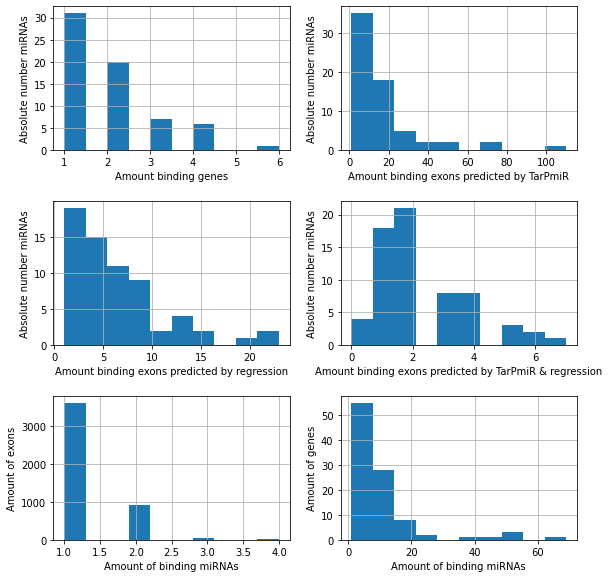

In [51]:
#plot histograms per mirna model
fig1, ax1 = plt.subplots(3, 2,figsize=(8,8))
plt.tight_layout(h_pad=3,w_pad=2)
mirna_level = bs.groupby('miRNA').agg({'binding_net':'sum','binding_tarpmir':'sum','coefficient':(lambda x: list(x)),'common':'sum','gene_id':(lambda x: len(set(x))),'exon_id':'count','miRNA':'first'})
mirna_level['gene_id'].hist(ax=ax1[0,0])
ax1[0,0].set_ylabel("Absolute number miRNAs")
ax1[0,0].set_xlabel("Amount binding genes")
mirna_level['binding_tarpmir'].hist(ax=ax1[0,1])
ax1[0,1].set_ylabel("Absolute number miRNAs")
ax1[0,1].set_xlabel("Amount binding exons predicted by TarPmiR")
mirna_level['binding_net'].hist(ax=ax1[1,0])
ax1[1,0].set_ylabel("Absolute number miRNAs")
ax1[1,0].set_xlabel("Amount binding exons predicted by regression")
mirna_level['common'].hist(ax=ax1[1,1])
ax1[1,1].set_ylabel("Absolute number miRNAs")
ax1[1,1].set_xlabel("Amount binding exons predicted by TarPmiR & regression")
bs.groupby('exon_id')['miRNA'].agg('count').hist(ax=ax1[2,0])
ax1[2,0].set_ylabel("Amount of exons")
ax1[2,0].set_xlabel("Amount of binding miRNAs")
bs.groupby('ensembl_gene_id')['miRNA'].agg('count').hist(ax=ax1[2,1])
ax1[2,1].set_ylabel("Amount of genes")
ax1[2,1].set_xlabel("Amount of binding miRNAs")
plt.savefig(tcga_path/'plots'/f'reg{reg_nr}_percent_plots.png',bbox_inches = "tight",dpi=200)

Coefficients of exons with bindingsites predicted by both TarPmiR and regression range from -0.076 to -0.000027.
Coefficients of exons with bindingsites predicted by only elastic net regression range from -0.058 to -0.000036.
Coefficients of exons with bindingsites predicted by only TarPmiR with prob > 0.8 range from -0.000 to 0.016427.
Coefficients of exons with bindingsites predicted by neither of the both methods range from -0.000 to 0.016834.


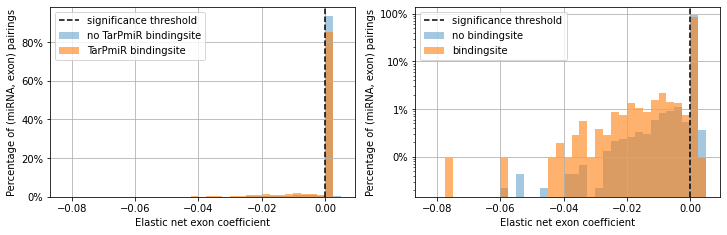

In [52]:
#plot coefficient histograms bs vs no bs
bs_both = bs[bs.binding_tarpmir & bs.binding_net]
bs_only = bs[~bs.binding_tarpmir & bs.binding_net]
bs_0 = bs[~bs.binding_tarpmir & ~bs.binding_net]
bs_1 = bs[bs.binding_tarpmir & ~bs.binding_net]
print(f'Coefficients of exons with bindingsites predicted by both TarPmiR and regression range from {bs_both.coefficient.min():.3f} to {bs_both.coefficient.max():.6f}.')
print(f'Coefficients of exons with bindingsites predicted by only elastic net regression range from {bs_only.coefficient.min():.3f} to {bs_only.coefficient.max():.6f}.')
print(f'Coefficients of exons with bindingsites predicted by only TarPmiR with prob > 0.8 range from {bs_1.coefficient.min():.3f} to {bs_1.coefficient.max():.6f}.')
print(f'Coefficients of exons with bindingsites predicted by neither of the both methods range from {bs_0.coefficient.min():.3f} to {bs_0.coefficient.max():.6f}.')

fig1, ax1 = plt.subplots(1, 2,figsize=(12,3.5))
bins_ = np.arange(-0.08125,0.005125,0.0025) if disease=='KICH' else np.arange(-0.041875,0.0051875,0.00125)
bs_only.coefficient.hist(bins=bins_, align='left', label='no TarPmiR bindingsite',alpha=0.4,ax=ax1[0],color='tab:blue',weights=np.ones_like(bs_only[bs_only.columns[0]]) / len(bs_only+bs_0))
bs_both.coefficient.hist(bins=bins_, align='left', label='TarPmiR bindingsite',alpha=0.6,ax=ax1[0],color='tab:orange',weights=np.ones_like(bs_both[bs_both.columns[0]]) / len(bs_both+bs_1))
bs_0.coefficient.hist(bins=bins_, align='right', label='_no bindingsite',alpha=0.4,ax=ax1[0],color='tab:blue', weights=np.ones_like(bs_0[bs_0.columns[0]]) / len(bs_only+bs_0))
bs_1.coefficient.hist(bins=bins_, align='right', label='_bindingsite',alpha=0.6,ax=ax1[0],color='tab:orange', weights=np.ones_like(bs_1[bs_1.columns[0]])/ len(bs_both+bs_1))
ax1[0].set_ylabel("Percentage of (miRNA, exon) pairings")
ax1[0].set_xlabel("Elastic net exon coefficient")
ax1[0].axvline(x = 0, color = 'black', linestyle="--",label='significance threshold') 
ax1[0].yaxis.set_major_formatter(PercentFormatter(1.0,decimals=0))
ax1[0].legend()
bs_only.coefficient.hist(bins = bins_, align='left', label='no bindingsite',alpha=0.4,ax=ax1[1],color='tab:blue',weights=np.ones_like(bs_only[bs_only.columns[0]]) / len(bs_only+bs_0))
bs_both.coefficient.hist(bins = bins_, align='left', label='bindingsite',alpha=0.6,ax=ax1[1],color='tab:orange',weights=np.ones_like(bs_both[bs_both.columns[0]]) / len(bs_both+bs_1))
bs_0.coefficient.hist(bins=bins_, align='right', label='_no bindingsite',alpha=0.4,ax=ax1[1],color='tab:blue', weights=np.ones_like(bs_0[bs_0.columns[0]]) / len(bs_only+bs_0))
bs_1.coefficient.hist(bins=bins_, align='right', label='_bindingsite',alpha=0.6,ax=ax1[1],color='tab:orange', weights=np.ones_like(bs_1[bs_1.columns[0]])/ len(bs_both+bs_1))
ax1[1].set_ylabel("Percentage of (miRNA, exon) pairings")
ax1[1].set_xlabel("Elastic net exon coefficient")
ax1[1].set_yscale('log')
ax1[1].yaxis.set_major_formatter(PercentFormatter(1.0,decimals=0))
ax1[1].axvline(x = 0, color = 'black', linestyle="--",label='significance threshold') 
ax1[1].legend()
plt.savefig(tcga_path/'plots'/f'reg{reg_nr}_bs_vs_nbs.png',bbox_inches = "tight",dpi=200)

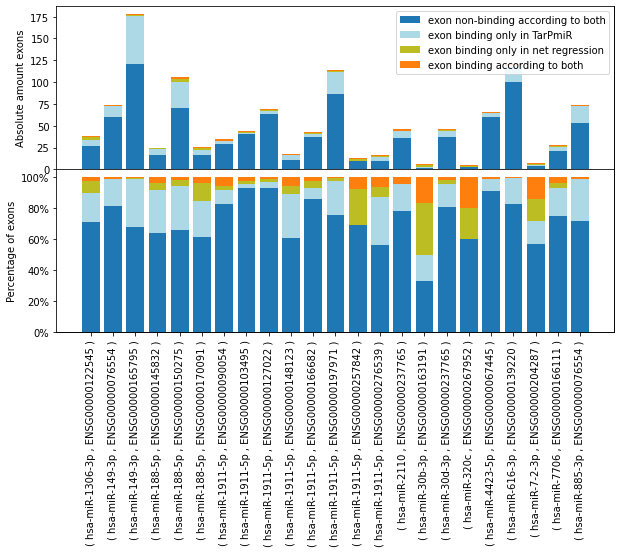

In [29]:
#plot exon distribution
if regression_mirna:
    figsize = (22,9) if disease=='KICH' else (14,8)
    fig1, axs = plt.subplots(figsize=figsize)
    axs.set(xticks=[],yticks=[])
    gs = fig1.add_gridspec(3, hspace=0)
    (ax1,ax2,ax3) = gs.subplots(sharex=True)
    mirna_level = bs.groupby('miRNA').agg({'binding_net':'sum','coefficient':(lambda x: list(x)),'common':'sum','gene_id':(lambda x: len(set(x))),'exon_id':'count','miRNA':'first'})
    ax1.bar(mirna_level['gene_id'].index,mirna_level['gene_id'].values, color='tab:red',width=0.8)
    ax1.set_ylabel('Amount different genes')
    #ax1.set_yticks(range(min(mirna_level['ensembl_gene_id'].values), max(mirna_level['ensembl_gene_id'].values)+1))
    ax2.bar(mirna_level['exon_id'].index,mirna_level['exon_id'].values, color='tab:green',label='non binding exons',width=0.8)
    ax2.bar(mirna_level['binding_net'].index,mirna_level['binding_net'].values, color='tab:orange',label='binding exons',width=0.8)
    ax2.bar(mirna_level['common'].index,mirna_level['common'].values, color='tab:blue',label='common binding exons',width=0.8)
    ax2.set_ylabel('Amount exons')
    ax2.legend()
    ax3.bar(mirna_level['exon_id'].index,mirna_level['exon_id'].values / mirna_level['exon_id'].values, color='tab:green',label='non binding exons',width=0.8)
    ax3.bar(mirna_level['binding_net'].index,mirna_level['binding_net'].values / mirna_level['exon_id'].values, color='tab:orange',label='binding exons',width=0.8)
    ax3.bar(mirna_level['common'].index,mirna_level['common'].values / mirna_level['exon_id'].values, color='tab:blue',label='c',width=0.8)
    ax3.set_ylabel('Percentage of exons')
    ax3.yaxis.set_major_formatter(PercentFormatter(1))
    ax3.set_xticks(ax3.get_xticks())
    ax3.set_xticklabels(mirna_level.index,rotation=90, fontsize=7.5 if disease=='KICH' else 10)
    for ax in [ax1,ax2,ax3]:
        ax.label_outer()
else:
    figsize = (17,6) if disease=='KICH' else (10,6)
    fig1, axs = plt.subplots(figsize=figsize)
    axs.set(xticks=[],yticks=[])
    gs = fig1.add_gridspec(2, hspace=0)
    (ax2,ax3) = gs.subplots(sharex=True)
    bs['only_net'] = bs['binding_net'] & (~bs['binding_tarpmir'])
    bs['only_tarp'] = (~bs['binding_net']) & bs['binding_tarpmir']
    bs['nonbinding'] = (~bs['binding_net']) & (~bs['binding_tarpmir'])
    mirna_level = bs.groupby(['miRNA','gene_id']).agg({'only_net':'sum','only_tarp':'sum','common':'sum','nonbinding':'sum','gene_id':'first','exon_id':'count','miRNA':'first'})
    ax2.bar(range(len(mirna_level['exon_id'].index)), mirna_level['nonbinding'].values, color='tab:blue',label='exon non-binding according to both',width=0.8)
    ax2.bar(range(len(mirna_level['exon_id'].index)), mirna_level['only_tarp'].values, color='lightblue',label='exon binding only in TarPmiR',width=0.8,bottom=mirna_level['nonbinding'].values)
    ax2.bar(range(len(mirna_level['exon_id'].index)), mirna_level['only_net'].values, color='tab:olive',label='exon binding only in net regression',width=0.8,bottom=mirna_level['nonbinding'].values+mirna_level['only_tarp'].values)
    ax2.bar(range(len(mirna_level['exon_id'].index)), mirna_level['common'].values, color='tab:orange',label='exon binding according to both',width=0.8,bottom=mirna_level['nonbinding'].values+mirna_level['only_tarp'].values+mirna_level['only_net'].values)
    ax2.set_ylabel('Absolute amount exons')
    ax2.legend()
    ax3.bar(range(len(mirna_level['exon_id'].index)), mirna_level['nonbinding'].values / mirna_level['exon_id'].values, color='tab:blue',label='exon non-binding according to both',width=0.8)
    ax3.bar(range(len(mirna_level['exon_id'].index)), mirna_level['only_tarp'].values / mirna_level['exon_id'].values, color='lightblue',label='exon binding only in TarPmiR',width=0.8,bottom=(mirna_level['nonbinding'].values/ mirna_level['exon_id'].values))
    ax3.bar(range(len(mirna_level['exon_id'].index)), mirna_level['only_net'].values / mirna_level['exon_id'].values, color='tab:olive',label='exon binding only in net regression',width=0.8,bottom=(mirna_level['nonbinding'].values/ mirna_level['exon_id'].values)+(mirna_level['only_tarp'].values/ mirna_level['exon_id'].values))
    ax3.bar(range(len(mirna_level['exon_id'].index)), mirna_level['common'].values / mirna_level['exon_id'].values, color='tab:orange',label='exon binding according to both',width=0.8,bottom=(mirna_level['nonbinding'].values/ mirna_level['exon_id'].values)+(mirna_level['only_tarp'].values/ mirna_level['exon_id'].values)+(mirna_level['only_net'].values/ mirna_level['exon_id'].values))
    ax3.set_ylabel('Percentage of exons')
    ax3.yaxis.set_major_formatter(PercentFormatter(1))
    ax3.set_xticks(range(len(mirna_level)))
    ax3.set_xticklabels([str('( '+mirna_level.miRNA[i]+' , '+mirna_level.gene_id[i]+' )') for i in range(len(mirna_level))] , rotation=90, fontsize=10)
    for ax in [ax2,ax3]:
        ax.label_outer()
plt.savefig(tcga_path/'plots'/f'reg{reg_nr}_exon_plots.png',bbox_inches = "tight",dpi=200)

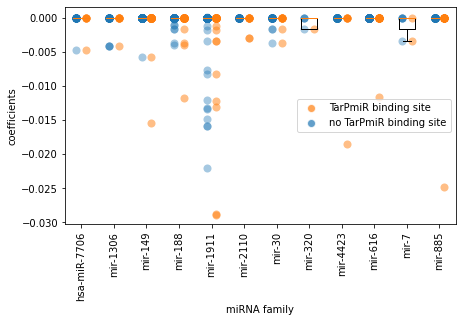

In [30]:
#plot coefficients per mirna family | color by binding_tarpmir or not
figsize = (7,4) if ((disease=='LGG') & (not regression_mirna)) else (12,4)
fig1, ax1 = plt.subplots(figsize=figsize)
mirna_level = bs.groupby('mirna_family').agg({'coefficient':(lambda x: list(x)),'binding_tarpmir':(lambda x: list(x)),'gene_id':(lambda x: len(set(x))),'exon_id':'count','mirna_family':'first','miRNA':(lambda x: list(x))})
plt.xlabel('miRNA family')
plt.ylabel('coefficients')
ax1.boxplot(mirna_level.coefficient.to_list(), showfliers=False)
ax1.set_xticklabels(mirna_level.mirna_family, rotation=90)
for i in range(len(mirna_level)):
    y = mirna_level.coefficient.to_list()[i]
    is_binding = mirna_level.binding_tarpmir.to_list()[i]
    y_bind = [y[val] for val in range(len(y)) if is_binding[val]]
    y_nonbind = [y[val] for val in range(len(y)) if not is_binding[val]]
    x_bind = np.array([i+1]*len(y_bind))+0.15
    x_nonbind = np.array([i+1]*len(y_nonbind))-0.15
    ax1.scatter(x_bind, y_bind, color='tab:orange', marker='o', linewidths=0, alpha=0.5, s=(20 if regression_mirna else (30 if (disease=='KICH') else 65)))
    ax1.scatter(x_nonbind, y_nonbind, color='tab:blue', marker='o', linewidths=0, alpha=0.4, s=(20 if regression_mirna else (30 if (disease=='KICH') else 65)))
legend_elements = [Line2D([0], [0], marker='o', markerfacecolor='tab:orange', color='w',label='TarPmiR binding site', markersize=8, alpha=0.7),
                   Line2D([0], [0], marker='o', markerfacecolor='tab:blue', color='w',label='no TarPmiR binding site', markersize=8, alpha=0.7)]
plt.legend(handles = legend_elements)
plt.savefig(tcga_path/'plots'/f'reg{reg_nr}_coeff_fam.png',bbox_inches = "tight",dpi=200)

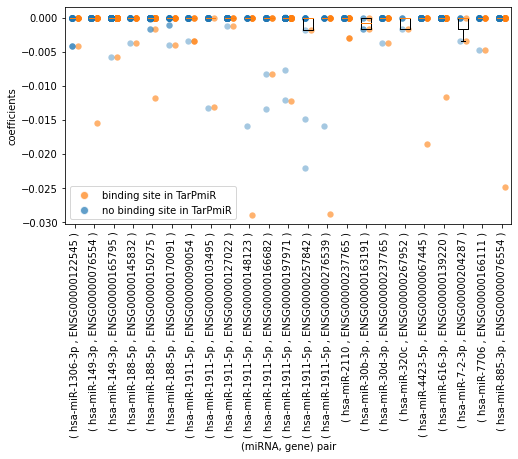

In [31]:
#plot coefficients per mirna & gene | color by binding_tarpmir or not
figsize = (22,5) if disease=='KICH' else ((16,4) if regression_mirna else (8,4))
fig1, ax1 = plt.subplots(figsize=figsize)
mirna_level = bs.groupby(('miRNA' if regression_mirna else ['miRNA','gene_id'])).agg({'binding_net':'sum','coefficient':(lambda x: list(x)),'binding_tarpmir':(lambda x: list(x)),'exon_id':'count','miRNA':'first','gene_id':'first'})
plt.xlabel(('miRNA' if regression_mirna else '(miRNA, gene) pair'))
plt.ylabel('coefficients')
ax1.boxplot(mirna_level.coefficient.to_list(), showfliers=False)
labels = mirna_level.miRNA if regression_mirna else [str('( '+mirna_level.miRNA[i]+' , '+mirna_level.gene_id[i]+' )') for i in range(len(mirna_level))] 
ax1.set_xticklabels(labels, rotation=90, fontsize=(7.5 if (regression_mirna & (disease=='KICH')) else 10))
for i in range(len(mirna_level)):
    y = mirna_level.coefficient.to_list()[i]
    is_binding = mirna_level.binding_tarpmir.to_list()[i]
    y_bind = [y[val] for val in range(len(y)) if is_binding[val]]
    y_nonbind = [y[val] for val in range(len(y)) if not is_binding[val]]
    x_bind = np.array([i+1]*len(y_bind))+0.15
    x_nonbind = np.array([i+1]*len(y_nonbind))-0.15
    ax1.scatter(x_bind, y_bind, color='tab:orange', marker='o', linewidths=0, s=40 if ((disease=='LGG') & (not regression_mirna)) else 15, alpha=0.6)
    ax1.scatter(x_nonbind, y_nonbind, color='tab:blue', marker='o', linewidths=0, s=40 if ((disease=='LGG') & (not regression_mirna)) else 15, alpha=0.4)
legend_elements = [Line2D([0], [0], marker='o', markerfacecolor='tab:orange', color='w',label='binding site in TarPmiR', markersize=8, alpha=0.7),
                   Line2D([0], [0], marker='o', markerfacecolor='tab:blue', color='w',label='no binding site in TarPmiR', markersize=8, alpha=0.7)]
plt.legend(handles = legend_elements)
plt.savefig(tcga_path/'plots'/f'reg{reg_nr}_coeff_model.png',bbox_inches = "tight",dpi=200)

## Fisher exact test

In [74]:
bs_sig = len(bs[bs.binding_tarpmir & bs.binding_net])
nbs_sig = len(bs[(~ bs.binding_tarpmir) & bs.binding_net])
bs_nsig = len(bs[bs.binding_tarpmir & (~ bs.binding_net)])
nbs_nsig = len(bs[(~ bs.binding_tarpmir) & (~ bs.binding_net)])
print(f'bs & significant coeff: {bs_sig}\nno bs & significant coeff: {nbs_sig} \nbs & no significant coeff: {bs_nsig}\nno bs & no significant coeff: {nbs_nsig}')
oddsratio, pvalue = stats.fisher_exact([[bs_sig, bs_nsig],[nbs_sig, nbs_nsig]], alternative='greater')
pvalue

bs & significant coeff: 26
no bs & significant coeff: 30 
bs & no significant coeff: 230
no bs & no significant coeff: 912


1.5734225036813954e-05

## Analyse binding exons in coding vs noncoding regions

In [ ]:
#barplot with the exons predicted as binding by both TarPmiR and elastic net and the percentage of coding vs noncoding.
#uses human reference genome GRCh38
data = EnsemblRelease(81)

def write_exons_to_file(bs):
    bs = bs[bs.common].copy().drop('ensembl_transcript_id',axis=1)
    bs['transcript_ids'] = bs.apply(lambda x: data.transcript_ids_of_gene_id(x.gene_id),axis=1)
    bs['transcript_ids'] = bs.apply(lambda x: [t for t in x.transcript_ids if x.exon_id in data.exon_ids_of_transcript_id(t)],axis=1) #get transcript ids by exon id
    file=open(tcga_path/'binding_exons_to_get_coding_info_biomart.txt','w')
    file.write(','.join(list(bs.exon_id)))
    file.close()

write_exons_to_file(bs)

In [ ]:
#HERE manually query ENSEMBL from https://www.ensembl.org/biomart/
#download Genomic coding start,  Genomic coding end, Exon region start (bp), Exon region end (bp), Exon stable ID

coding
coding            4
not_coding       17
partly_coding    13
Name: Exon stable ID, dtype: int64 
 sum: 34


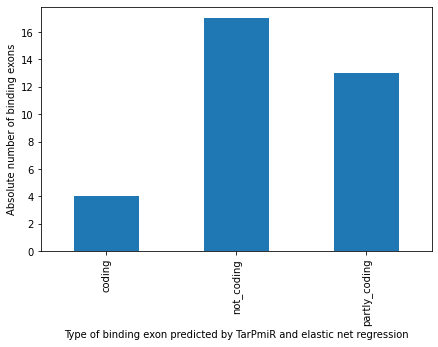

In [41]:
def is_coding(exons):
    if (exons['Genomic coding start'] == exons['Exon region start (bp)']) and (exons['Genomic coding end'] == exons['Exon region end (bp)']): return 'coding'
    if np.isnan(exons['Genomic coding end']): return 'not_coding'
    else: return 'partly_coding'
    
def read_and_plot_coding_annotation():
    exons = pd.read_csv(tcga_path/"all_binding_exons_with_coding_start_end_from_mart_export.txt")
    exons['coding'] = exons.apply(lambda x: is_coding(x),axis=1)
    fig1, axs = plt.subplots(figsize=(7,4.5))
    exons.groupby('coding')['Exon stable ID'].count().plot(kind='bar')
    print(exons.groupby('coding')['Exon stable ID'].count(),'\n sum:',exons.groupby('coding')['Exon stable ID'].count().sum())
    axs.set_ylabel('Absolute number of binding exons')
    axs.set_xlabel('Type of binding exon predicted by TarPmiR and elastic net regression')#'Position of binding site predicted by TarPmiR and elastic net regression')
    plt.savefig(tcga_path/'plots'/f'reg{reg_nr}_ecoding.png',bbox_inches = "tight",dpi=200)
read_and_plot_coding_annotation()

In [ ]:
#barplot with the transcripts predicted as binding by both TarPmiR and elastic net and the percentage of coding vs noncoding.
#uses human reference genome GRCh38
data = EnsemblRelease(81)

def write_transcripts_to_file(bs):
    bs = bs[bs.common].copy().drop_duplicates(subset='ensembl_transcript_id')
    file=open(tcga_path/'binding_transcripts_to_get_coding_info_biomart.txt','w')
    file.write(','.join(list(bs.ensembl_transcript_id)))
    file.close()

write_transcripts_to_file(bs)

In [ ]:
#HERE manually query ENSEMBL from https://www.ensembl.org/biomart
#download Gene stable ID 	Transcript stable ID 	Transcript type

Transcript type
lncRNA                     17
nonsense_mediated_decay     5
processed_transcript       17
protein_coding             74
retained_intron            15
Name: Transcript stable ID, dtype: int64 
 sum: 128


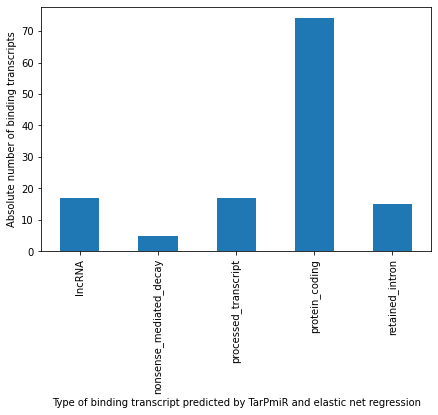

In [83]:
def read_and_plot_coding_annotation():
    transcripts = pd.read_csv(tcga_path/"all_binding_transcripts_with_coding_start_end_from_mart_export.txt")
    fig1, axs = plt.subplots(figsize=(7,4.5))
    print(transcripts.groupby('Transcript type')['Transcript stable ID'].count(), '\n sum:',transcripts.groupby('Transcript type')['Transcript stable ID'].count().sum())
    transcripts.groupby('Transcript type')['Transcript stable ID'].count().plot(kind='bar')
    axs.set_ylabel('Absolute number of binding transcripts')
    axs.set_xlabel('Type of binding transcript predicted by TarPmiR and elastic net regression')
    plt.savefig(tcga_path/'plots'/f'reg{reg_nr}_tcoding.png',bbox_inches = "tight",dpi=200)
read_and_plot_coding_annotation()

## Finding interesting (miRNA, gene) examples

In [ ]:
#plot miRNA - exon expressions for all combinations

#### change HERE ####
#True: run just for genes with coding binding transcripts, False: run for all binding genes
coding = False
#####################
data = EnsemblRelease(81)
    
def load_data():
    file1 = Path(tcga_path/'unfiltered_transcript_expression.pickle')
    file2 = Path(tcga_path/'unfiltered_mirna_expression.pickle')
    if file1.is_file() and file2.is_file():
        transcript_counts = pd.read_pickle(file1)
        mirna_counts = pd.read_pickle(file2)
    else:
        mirna_counts = pd.read_csv(path/'tcga_miRNA', delimiter='	')
        transcript_counts = pd.read_csv(path/'tcga_Kallisto_tpm', sep='\t')
        transcript_counts['sample'] = transcript_counts['sample'].str.split('.',expand=True)[0]
        used_samples = list(transcript_counts.columns & mirna_counts.columns)
        transcript_counts = transcript_counts[used_samples]
        mirna_counts = mirna_counts[used_samples]
        transcript_counts.to_pickle(tcga_path/'unfiltered_transcript_expression.pickle')
        mirna_counts.to_pickle(tcga_path/'unfiltered_mirna_expression.pickle')
    return transcript_counts, mirna_counts
transcript_counts, mirna_counts = load_data()

binding_transcripts = bs[bs.common][['ensembl_transcript_id','miRNA']]
binding_genes = bs[bs.common][['miRNA','gene_id']].values

if coding: 
    coding_transcripts = pd.read_csv(tcga_path/"all_binding_transcripts_with_coding_start_end_from_mart_export.txt")
    coding_genes = coding_transcripts[coding_transcripts['Transcript type'] == 'protein_coding']['Gene stable ID'].drop_duplicates().values
    binding_genes = [[miRNA,gene] for [miRNA,gene] in binding_genes if gene in coding_genes]
    
name_file = 'mirna_transcript_expressions'
if coding: name_file += '_coding'
if not (tcga_path/'plots'/name_file).exists():
    !mkdir $tcga_path/'plots'/$name_file
    
for miRNA, gene in list(binding_genes):
    here_mirna_counts = mirna_counts[mirna_counts["sample"] == miRNA].drop('sample',axis=1)
    here_binding_transcripts = binding_transcripts[binding_transcripts["miRNA"] == miRNA].ensembl_transcript_id.drop_duplicates()
    transcript_counts['binding'] = transcript_counts['sample'].apply(lambda x: x in list(here_binding_transcripts))
    transcripts = data.transcript_ids_of_gene_id(gene)
    fig1, axs = plt.subplots(figsize=(6,6))
    colors = {True:'tab:orange', False:'tab:blue'}
    for t in list(transcript_counts[transcript_counts['sample'].apply(lambda x: x in transcripts)]['sample']):
        here_transcript_counts = transcript_counts[transcript_counts['sample'] == t].drop('sample',axis=1)
        plt.scatter(here_transcript_counts.drop('binding',axis=1), here_mirna_counts, c=here_transcript_counts['binding'].map(colors), alpha=0.1)
        plt.title(f'({miRNA},{gene})')
        axs.set_xlabel('transcript expression in log2(tpm+0.001)')
        axs.set_ylabel('miRNA expression in log2(norm_value+1)')
    plt.savefig(tcga_path/'plots'/name_file/f'{gene}_{miRNA}.png') 
    plt.close()

In [88]:
#find (miRNA, gene) pairs where most negative coefficient also binding site in TarPmiR
bs['min_coefficient'] = bs.coefficient
bs['index_min_coefficient'] = bs.coefficient
mirna_level = bs.groupby(['miRNA','gene_id']).agg({'index_min_coefficient': lambda x: [i for i, coeff in enumerate(x) if coeff == min(x)][0],'coefficient':(lambda x: list(x)),'min_coefficient':(lambda x: min(x)),'binding_tarpmir':(lambda x: list(x)),'exon_id':(lambda x: list(x))})
mirna_level = mirna_level.reset_index()
mirna_level['index_min_coefficient'] = mirna_level['index_min_coefficient'].astype(int)
mirna_level['min_binding_tarpmir'] = mirna_level.apply(lambda row : row.binding_tarpmir[row.index_min_coefficient],axis=1)
mirna_level['binding_exon'] = mirna_level.apply(lambda row : row.exon_id[row.index_min_coefficient],axis=1)
mirna_level['var_coefficients'] = mirna_level.apply(lambda row : statistics.variance(row.coefficient),axis=1)
bs.drop(['min_coefficient','index_min_coefficient'],axis=1)
print(f'Of {len(mirna_level)} (mirna,gene) pairs')
mirna_level = mirna_level[mirna_level['min_binding_tarpmir']].drop('min_binding_tarpmir',axis=1)
print(f'for {len(mirna_level)} (mirna,gene) pairs the most negative coefficient is also for an TarPmiR binding exon with {len(mirna_level.miRNA.drop_duplicates())} different miRNAs and {len(mirna_level.gene_id.drop_duplicates())} different genes.')
biggest_var = mirna_level.nlargest(3,'var_coefficients')
print('biggest variance:\n',biggest_var[['miRNA','gene_id','var_coefficients','min_coefficient']])
smallest_coeff = mirna_level.nsmallest(3,'min_coefficient')
print('smallest coefficient:\n',smallest_coeff[['miRNA','gene_id','var_coefficients','min_coefficient']])
bs = bs.drop(['index_min_coefficient','min_coefficient'],axis=1)
bs_interesting = bs.merge(mirna_level[['miRNA','gene_id']],how='inner')
bs_interesting

Of 122 (mirna,gene) pairs
for 68 (mirna,gene) pairs the most negative coefficient is also for an TarPmiR binding exon with 43 different miRNAs and 62 different genes.
biggest variance:
               miRNA          gene_id  var_coefficients  min_coefficient
11  hsa-miR-1301-3p  ENSG00000204464          0.001933        -0.076151
99  hsa-miR-6718-5p  ENSG00000279579          0.000360        -0.032847
94  hsa-miR-664b-3p  ENSG00000276886          0.000271        -0.032902
smallest coefficient:
               miRNA          gene_id  var_coefficients  min_coefficient
11  hsa-miR-1301-3p  ENSG00000204464          0.001933        -0.076151
7      hsa-miR-1293  ENSG00000138678          0.000118        -0.043326
59     hsa-miR-3651  ENSG00000231225          0.000072        -0.040913


,miRNA,gene_id,exon_id,coefficient,ensembl_transcript_id,ensembl_gene_id,ensembl_gene_id_version,binding_probability,binding_tarpmir,binding_net,common,mirna_family
0,hsa-miR-1301-3p,ENSG00000204464,ENSE00001795642,0.000000,ENST00000424792,ENSG00000204464,ENSG00000204464.7,[1.0],True,False,False,mir-1301
1,hsa-miR-1301-3p,ENSG00000204464,ENSE00003781915,-0.000000,ENST00000424792,ENSG00000204464,ENSG00000204464.7,[0.9230769230769232],True,False,False,mir-1301
2,hsa-miR-1301-3p,ENSG00000204464,ENSE00003758055,-0.076151,ENST00000625027,ENSG00000204464,ENSG00000204464.7,[1.0],True,True,True,mir-1301
3,hsa-miR-1301-3p,ENSG00000236939,ENSE00001612598,-0.025036,ENST00000436771,ENSG00000236939,ENSG00000236939.2,"[0.8461538461538461, 0.9230769230769232]",True,True,True,mir-1301
4,hsa-miR-1301-3p,ENSG00000236939,ENSE00002108875,-0.000000,ENST00000521246,ENSG00000236939,ENSG00000236939.2,"[0.8461538461538461, 0.8461538461538461]",True,False,False,mir-1301
...,...,...,...,...,...,...,...,...,...,...,...,...
3138,hsa-miR-935,ENSG00000163832,ENSE00001734663,-0.028281,NaN,NaN,NaN,NaN,False,True,False,mir-935
3139,hsa-miR-935,ENSG00000163832,ENSE00001818671,-0.000000,NaN,NaN,NaN,NaN,False,False,False,mir-935
3140,hsa-miR-935,ENSG00000163832,ENSE00001811169,0.000000,NaN,NaN,NaN,NaN,False,False,False,mir-935
3141,hsa-miR-935,ENSG00000163832,ENSE00003601596,0.000000,ENST00000485029,ENSG00000163832,ENSG00000163832.16,[0.9230769230769232],True,False,False,mir-935


In [89]:
#check those genes:
genes = ['ENSG00000204464','ENSG00000146955']
for gene in genes:
    print(gene,bs_interesting[bs_interesting.gene_id == gene][['miRNA','exon_id','coefficient','common']])

ENSG00000204464              miRNA          exon_id  coefficient  common
0  hsa-miR-1301-3p  ENSE00001795642     0.000000   False
1  hsa-miR-1301-3p  ENSE00003781915    -0.000000   False
2  hsa-miR-1301-3p  ENSE00003758055    -0.076151    True
ENSG00000146955                miRNA          exon_id  coefficient  common
2724  hsa-miR-324-3p  ENSE00001956705    -0.000000   False
2725  hsa-miR-324-3p  ENSE00001884985     0.000000   False
2726  hsa-miR-324-3p  ENSE00001155572    -0.021898    True
2727  hsa-miR-324-3p  ENSE00001805995    -0.000000   False
2728  hsa-miR-324-3p  ENSE00001155567    -0.000000   False
2729  hsa-miR-324-3p  ENSE00001843508    -0.000000   False
